# Coronavirus

Explore discussions on Twitter about coronavirus.

## Import libraries

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tldextract
import networkx as nx

from datetime import date
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image

plt.style.use('seaborn')
pd.set_option('display.max_colwidth', None)

In [2]:
# Class to embed tweets
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

## Load data

In [3]:
tweets = pd.read_csv('data/tweets_010119_250120.csv', parse_dates=['formatted_date'])

In [4]:
tweets.shape

(321180, 20)

## Process data

In [5]:
# remove columns used in the search
tweets.drop(['key', 'key_group', 'key_mention', 'key_group_mention'], axis=1, inplace=True)

In [6]:
# rename columns
tweets.rename(columns={'date': 'datetime', 'formatted_date': 'formatted_datetime'}, inplace=True)

In [7]:
tweets.head()

,tweet_id,user_id,tweet,datetime,formatted_datetime,retweets,favorites,mentions,hashtags,geo,urls,permalink,username,lang,tweet_length,word_count
0,1220134080932696072,1057027456765452293,The continuing 2019-nCoV epidemic threat of no...,2020-01-23 01:00:08,2020-01-23 01:00:08+00:00,0,0,NaN,#science #research,NaN,https://www.ncbi.nlm.nih.gov/m/pubmed/31953166/,https://twitter.com/researchphilia/status/1220...,researchphilia,es,273,36
1,1220134674887892993,165080514,BREAKING: The Wuhan #coronavirus most likely c...,2020-01-23 01:02:30,2020-01-23 01:02:30+00:00,174,188,NaN,#coronavirus #2019nCoV #WuhanCoronavirus #wuha...,NaN,https://onlinelibrary.wiley.com/doi/abs/10.100...,https://twitter.com/richardvolle/status/122013...,richardvolle,es,219,22
2,1220134704529190913,1102688399570452480,"Lo más correcto sería ponerle "" 2019-nCoV "", y...",2020-01-23 01:02:37,2020-01-23 01:02:37+00:00,0,0,NaN,NaN,NaN,NaN,https://twitter.com/FauReyC/status/12201347045...,FauReyC,es,147,24
3,1220135328050184192,1663541358,No existe vacuna ni tratamiento disponible par...,2020-01-23 01:05:05,2020-01-23 01:05:05+00:00,0,0,NaN,#recomendaciones #coronavirus,NaN,http://ow.ly/2trt50y2pAa,https://twitter.com/QuadratinMexico/status/122...,QuadratinMexico,es,180,25
4,1220135597320409089,223226324,New analysis on @biorxivpreprint from Michael ...,2020-01-23 01:06:10,2020-01-23 01:06:10+00:00,3,6,@biorxivpreprint @NIH,#2019nCoV,NaN,https://www.biorxiv.org/content/10.1101/2020.0...,https://twitter.com/nycbat/status/122013559732...,nycbat,es,176,21


In [8]:
# remove empty rows
tweets.dropna();

In [9]:
tweets.shape

(321180, 16)

In [10]:
# remove duplicates
unique_tweet_ids = tweets.tweet_id.unique()
tweets.drop_duplicates(subset='tweet_id', keep='first', inplace = True) 

In [11]:
assert tweets.shape[0]==len(unique_tweet_ids), 'Drop duplicate operation failed!'

In [12]:
# create a date colum
tweets['date'] = tweets.loc[:,'formatted_datetime'].dt.date

Filter out tweets that are older than 31st December 2019, date of the [first reported case](https://www.who.int/emergencies/diseases/novel-coronavirus-2019) of coronavirus

In [13]:
start_date = date(2019, 12, 31)
start_date = pd.to_datetime(start_date, utc=False)
tweets = tweets[tweets['date'] >= start_date]

In [14]:
tweets.shape

(317399, 17)

---
## Evolution of tweets over time

In [15]:
# group tweets by date
tweets_by_date = tweets.groupby('date', as_index=False).count()

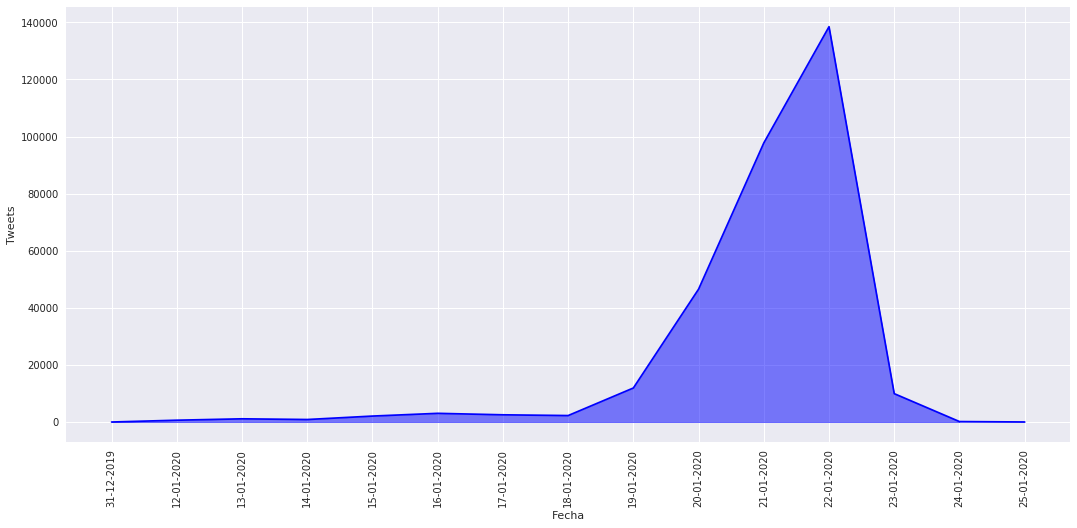

In [16]:
plt.figure(figsize=(18,8))
x_dates = list(pd.to_datetime(tweets_by_date['date']).dt.strftime('%d-%m-%Y'))
y_counts = list(tweets_by_date['tweet_id'])
fig = sns.lineplot(x=x_dates, y=y_counts, color='blue')
fig.set(xlabel='Fecha', ylabel='Tweets')
sns.set_style("dark", {'axes.grid': True})
fig.set_xticklabels(labels=x_dates, rotation=90)
plt.fill_between(x_dates, y_counts, alpha=0.5, color='blue')
plt.show()
#fig.get_figure().savefig("tweets_over_time.png", dpi=200, quality=95, bbox_inches="tight")

Let's explore what happened from 20-01-2020 onwards

In [17]:
start_date = pd.to_datetime(date(2020, 1, 21), utc=False)
end_date = pd.to_datetime(date(2020, 1, 23), utc=False)
tweets_bulk_period = tweets[(tweets['date'] >= start_date) & (tweets['date'] >= start_date)]

In [18]:
tweets_bulk_period.shape

(292911, 17)

In [19]:
print('{}% of all tweets were generated during this period'.format(
      round(100*tweets_bulk_period.shape[0]/tweets.shape[0], 0)))

92.0% of all tweets were generated during this period


In [20]:
# get hour of tweets
tweets_bulk_period['date_hour'] = tweets_bulk_period.loc[:,'formatted_datetime'].dt.strftime('%d-%m-%Y %H')

/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
# group tweets by date and hour
tweets_bulk_period_by_date_hour = tweets_bulk_period.groupby('date_hour').count()

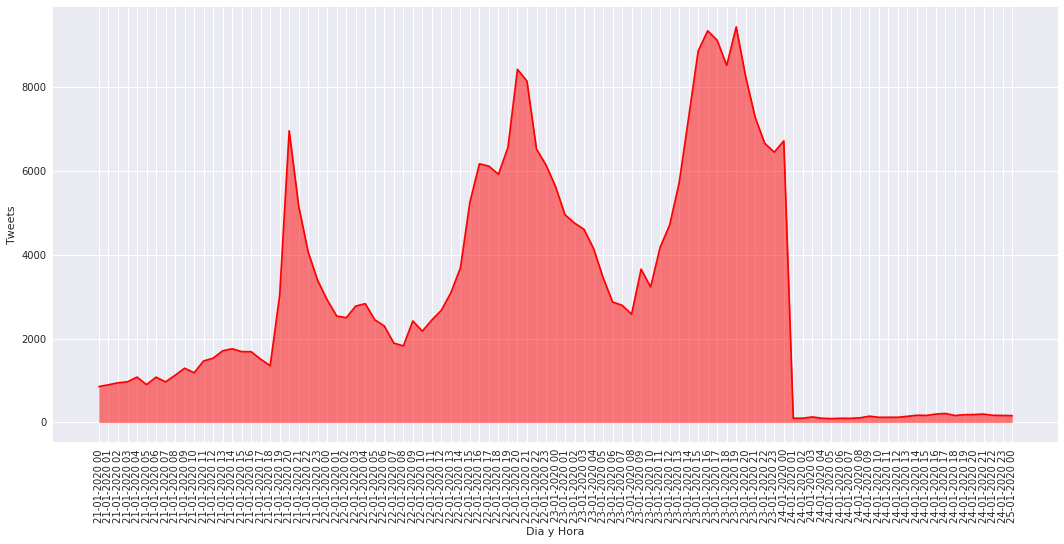

In [22]:
plt.figure(figsize=(18,8))
x_dates = list(tweets_bulk_period_by_date_hour.index)
y_counts = list(tweets_bulk_period_by_date_hour['tweet_id'])
fig = sns.lineplot(x=x_dates, y=y_counts, color='red')
fig.set(xlabel='Dia y Hora', ylabel='Tweets')
sns.set_style('dark', {'axes.grid': True})
fig.set_xticklabels(labels=x_dates, rotation=90)
plt.fill_between(x_dates, y_counts, alpha=0.5, color='red')
plt.show()

---

## Tweet Authors

In [23]:
tweets_by_author = tweets.groupby('username')

In [24]:
total_authors = len(tweets_by_author.groups)

In [25]:
print('There are {0} Twitter users that have posted tweets about coronavirus'.format(total_authors))

There are 172885 Twitter users that have posted tweets about coronavirus


#### Top-50 most active authors

In [26]:
tweets_authors_count = tweets_by_author.count()

In [27]:
tweets_authors_count.sort_values('tweet_id', ascending=False).head(50).index

Index(['PneumoniaWuhan', 'r__worldnews', 'poandpo', 'AndyVermaut',
       'ZyroFoxtrot', 'emiliomordini', 'TheArticleTrunk', 'AnalyticaGlobal',
       'mlnangalama', 'twosheeep1', 'dev_discourse', 'News247WorldPre',
       'makoto_au_japon', 'ElNacionalWeb', 'peruenlanoticia',
       'contrapuntovzla', 'raybae689', 'la_patilla', 'JCSura', '4PawShop',
       'dailystar', 'noticiasdelmun4', 'TheTop10News2', 'WHO', 'CNNEE',
       '24sante_fr', 'lasillarota', 'FluTrackers', 'crewislife',
       'XavierAbadMdG', 'BaronianConsult', 'HernanPorrasM', 'greg_folkers',
       'CaraotaDigital', 'ABSCBNNews', 'FreieWeltEu', 'AfricanPeacemag',
       'El_Cooperante', 'QPEV_', 'PulpNews', 'Barbara96913515', 'k29664911',
       'MuruganHospita3', 'Milenio', 'DelilahVeronese', 'CapitalEdomex',
       'IndoPac_Info', 'greeenorg', 'FxBookLTTG', 'Apex_WW'],
      dtype='object', name='username')

In [28]:
active_authors = list(tweets_authors_count.sort_values('tweet_id', ascending=False).head(50)['tweet_id'].index)
active_authors_tweets = list(tweets_authors_count.sort_values('tweet_id', ascending=False).head(50)['tweet_id'])

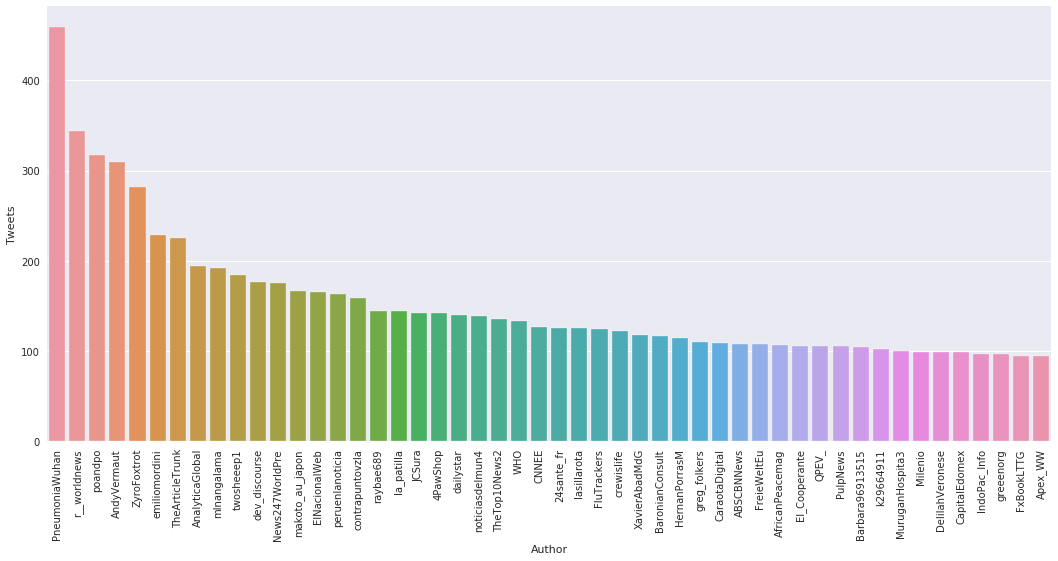

In [29]:
plt.figure(figsize=(18,8))
fig = sns.barplot(x=active_authors, y=active_authors_tweets)
fig.set(xlabel='Author', ylabel='Tweets')
fig.set_xticklabels(labels=active_authors, rotation=90)
plt.show()

#### Most mentioned users

In [30]:
tweets_with_mentions = tweets[~tweets['mentions'].isna()]

In [31]:
print('There are {} tweets with mentions in the text'.format(tweets_with_mentions.shape[0]))

There are 40287 tweets with mentions in the text


In [32]:
user_mentions = defaultdict(int)
for index, tweet in tweets_with_mentions.iterrows():
    mentions = tweet['mentions'].split()
    for mention in mentions:
        user_mentions[mention] += 1

In [33]:
user_mentions_df = pd.DataFrame.from_dict({'username': list(user_mentions.keys()), 
                                           'mention_count': list(user_mentions.values())})

In [34]:
# remove @ mention because there cannot be an user with @ as username
user_mentions_df = user_mentions_df[user_mentions_df['username']!='@']

Top-10 most mentioned users

In [35]:
# show the top-10 most mentioned users
user_mentions_df.sort_values('mention_count', ascending=False).head(10)

,username,mention_count
7,@WHO,2137
100,@YouTube,2128
15,@CDCgov,935
503,@MailOnline,698
873,@lopezobrador_,652
57,@SSalud_mx,503
325,@realDonaldTrump,493
617,@GoogleNews,441
56,@el_pais,330
593,@scmpnews,325


Top-50 most mentioned users

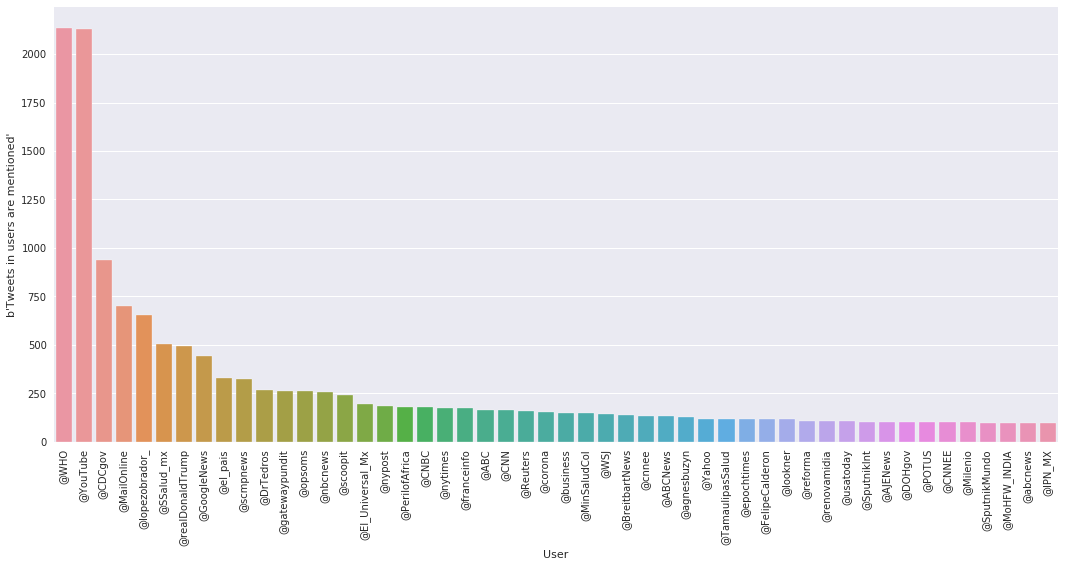

In [36]:
plt.figure(figsize=(18,8))
mentioned_users = list(user_mentions_df.sort_values('mention_count', ascending=False).head(50)['username'])
mentions_count = list(user_mentions_df.sort_values('mention_count', ascending=False).head(50)['mention_count'])
fig = sns.barplot(x=mentioned_users, y=mentions_count)
fig.set(xlabel='User', ylabel=b'Tweets in users are mentioned')
fig.set_xticklabels(labels=mentioned_users, rotation=90)
plt.show()

#### Tweets that mention surprised users (e.g., @YouTube, @lopezobrador, @SSalud_mx, @realDonaldTrump)

Tweets that mention **`@Youtube`**

In [37]:
tweets[tweets['mentions'].isin(['@YouTube'])][['tweet_id', 'username', 'tweet', 'datetime', 'urls', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,urls,retweets
236967,1219822897650372608,ElalborotoF,Mhoni Vidente predijo coronavirus que afectarí...,2020-01-22 04:23:36,https://youtu.be/_-0r7BP9zG8,28
167713,1220443236076072962,ShooterHatesYou,Bisogna preoccuparsi per il Coronavirus Cinese...,2020-01-23 21:28:36,https://youtu.be/R4d0LG8NuCk,22
251600,1219923774520406016,WyverShago,A Thread 1) Mysterious Coronavirus Confirmed i...,2020-01-22 11:04:27,https://youtu.be/BreUIR5jV_I,17
127171,1220371384120905728,Jabiertzo,China toma medidas drásticas contra epidemia d...,2020-01-23 16:43:06,https://youtu.be/tFS6oKgtvlk,14
186352,1220486240333635586,WyverShago,Update: Coronavirus Detected in Texas and Los ...,2020-01-24 00:19:29,https://youtu.be/yJ3ysUI9AN8,12
71672,1220191694332755969,WyverShago,#Coronavirus Two cases of Coronavirus suspecte...,2020-01-23 04:49:04,https://youtu.be/s7ABCJL5yhQ,11
312846,1220098024979886080,crnalexander,ALERTA DE SALUD POR BROTE EPIDEMIOLÓGICO DE NU...,2020-01-22 22:36:52,https://youtu.be/obSZMPoa9sc,10
188684,1220491499256864768,Michaelcraddo16,"Good vid... Coronavirus , Organic or Purposely...",2020-01-24 00:40:23,https://youtu.be/ZQOhja2Qnw4,9
246017,1219885122159357952,Annette_LEXA,Coronavirus en Chine : doit-on se sentir conce...,2020-01-22 08:30:52,https://youtu.be/qoBoryHuZ6E,9
154790,1220418697975812096,Liz_Estes,Coronavirus Patients Being Transported In Quar...,2020-01-23 19:51:06,https://youtu.be/AyF5UvEgz1Y,8


They are primarily videos posted through the Youtube's sharing function. The most retweeted one is shown below.

In [38]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="es" dir="ltr">Mhoni Vidente predijo coronavirus que afectaría a todo el mundo <a href="https://t.co/70gi3Y625t">https://t.co/70gi3Y625t</a> vía <a href="https://twitter.com/YouTube?ref_src=twsrc%5Etfw">@YouTube</a></p>&mdash; El Alboroto de los famosos (@ElalborotoF) <a href="https://twitter.com/ElalborotoF/status/1219822897650372608?ref_src=twsrc%5Etfw">January 22, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(tweet_html)

Tweets that mention **`@lopezobrador`**

In [39]:
tweets[tweets['mentions'].isin(['@lopezobrador'])][['tweet_id', 'username', 'tweet', 'datetime', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,retweets
139223,1220391793138655232,landayol07,El verdadero coronavirus lo tenemos en mexico ...,2020-01-23 18:04:11,2
262646,1219981557122969600,PdPagina,#FelizMiercoles el presidente @lopezobrador co...,2020-01-22 14:54:04,1
264563,1219987986739187714,alvarez_armando,En México hay un posible caso de #CoronaVirus ...,2020-01-22 15:19:36,1
274262,1220013197182357509,SilesJuarez,Agrega q tomo 40milmill del fondo de catástrof...,2020-01-22 16:59:47,1
263541,1219984749294309377,OroNoticiasPue,#ÚltimaHora El presidente Andrés Manuel López ...,2020-01-22 15:06:45,0
275357,1220015873186041856,GarzaZindy,Gadamdre y hasta cuándo te pronunciarás sobre ...,2020-01-22 17:10:25,0
313605,1220099825196097536,osonegro01,@lopezobrador Protegiendose del #coronavirus p...,2020-01-22 22:44:01,0


In [40]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="es" dir="ltr"><a href="https://twitter.com/hashtag/FelizMiercoles?src=hash&amp;ref_src=twsrc%5Etfw">#FelizMiercoles</a> el presidente <a href="https://twitter.com/lopezobrador?ref_src=twsrc%5Etfw">@lopezobrador</a> confirmó que hay un posible caso de <a href="https://twitter.com/hashtag/coronavirus?src=hash&amp;ref_src=twsrc%5Etfw">#coronavirus</a> en <a href="https://twitter.com/hashtag/Tamaulipas?src=hash&amp;ref_src=twsrc%5Etfw">#Tamaulipas</a>, explicó que el paciente está en observación.</p>&mdash; Pie de Página (@PdPagina) <a href="https://twitter.com/PdPagina/status/1219981557122969600?ref_src=twsrc%5Etfw">January 22, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(tweet_html)

Tweets that mention **`@SSalud_mx`**

In [41]:
tweets[tweets['mentions'].isin(['@SSalud_mx'])][['tweet_id', 'username', 'tweet', 'datetime', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,retweets
5793,1219412981005484033,MediCasos,Les dejamos este documento de la @SSalud_mx so...,2020-01-21 01:14:44,75
312639,1220097553607417863,CarlosLoret,Determina @SSalud_mx que darán cada 24 horas i...,2020-01-22 22:34:59,64
46005,1219733974450393090,Reforma,En medio de la nueva cepa del #coronavirus sur...,2020-01-21 22:30:15,42
296085,1220064823670661126,liderfiscal,La @SSalud_mx emite un aviso epidemiológico so...,2020-01-22 20:24:56,42
279299,1220025670715215873,CarlosTorresF_,Aquí algunos datos que debes conocer sobre el ...,2020-01-22 17:49:21,31
1975,1220388573955993601,RepasoENARMmx,Informe actualizado sobre el Nuevo CORONAVIRUS...,2020-01-23 17:51:24,27
116458,1220353706778120192,Pajaropolitico,La secretaría de @SSalud_mx informa que se han...,2020-01-23 15:32:51,24
276515,1220018818837372928,lajornadaonline,. @SSalud_mx confirmó que hay un posible caso ...,2020-01-22 17:22:07,23
69794,1220184482185007105,almagoch,La @SSalud_mx ha actualizado la información de...,2020-01-23 04:20:25,22
282847,1220034859470487552,almaguerpardo1,Hay una amenaza de enfermedad Catastrófica lla...,2020-01-22 18:25:52,22


In [42]:
tweet_html = (
"""<blockquote class="twitter-tweet"><p lang="es" dir="ltr">Les dejamos este documento de la <a href="https://twitter.com/SSalud_mx?ref_src=twsrc%5Etfw">@SSalud_mx</a> sobre coronavirus y la relación con <a href="https://twitter.com/hashtag/Wuhan?src=hash&amp;ref_src=twsrc%5Etfw">#Wuhan</a> <a href="https://t.co/Zim0TTKK4f">pic.twitter.com/Zim0TTKK4f</a></p>&mdash; El internista. (@MediCasos) <a href="https://twitter.com/MediCasos/status/1219412981005484033?ref_src=twsrc%5Etfw">January 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>"""
)
Tweet(tweet_html)

Tweets that mention **`@realDonaldTrump`**

In [43]:
tweets[tweets['mentions'].isin(['@realDonaldTrump'])][['tweet_id', 'username', 'tweet', 'datetime', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,retweets
187152,1220488147248861190,paulftheophilus,President @realDonaldTrump - close down the fl...,2020-01-24 00:27:04,90
117890,1220356138325200896,HanianEmpress,Free the refugees from the camps immediately @...,2020-01-23 15:42:31,62
290873,1220055192370143233,ElizabethEThorp,"Hard pass crimey, impeached President @realDon...",2020-01-22 19:46:40,42
148403,1220408445674848256,0ctoberReignz,#CoronaVirus @realDonaldTrump #QanonPhkYourPla...,2020-01-23 19:10:22,25
153980,1220417320482484225,0ctoberReignz,#CoronaVirus OMG - WTH????? November Of 2019 A...,2020-01-23 19:45:38,24
155511,1220419964420743174,gholland04,CDC raises Coronavirus Warning Level ... ...re...,2020-01-23 19:56:08,16
305819,1220082290996469763,DrJaneRuby,NO ENTRIES INTO US FROM CHINA - until this vir...,2020-01-22 21:34:20,14
305225,1220081198883577862,Notimex_TV,"| El presidente de Estados Unidos, @realDonald...",2020-01-22 21:30:00,14
171524,1220451751486279680,Tina_Mc_G,...then I checked for patents and BINGO! (I al...,2020-01-23 22:02:27,13
152372,1220414743661420544,0ctoberReignz,#CoronaVirus @realDonaldTrump #MASA #MakeAmeri...,2020-01-23 19:35:23,12


In [44]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">President <a href="https://twitter.com/realDonaldTrump?ref_src=twsrc%5Etfw">@realDonaldTrump</a> - close down the flights from Wuhan Coronavirus infected areas right now, before it is to late! <br>I believe drastic preventive measures must be taken. Better to be safe than sorry. <a href="https://t.co/Y7wSyJYCVt">https://t.co/Y7wSyJYCVt</a> <a href="https://t.co/HwdKaDtj5Y">pic.twitter.com/HwdKaDtj5Y</a></p>&mdash; Paul Theophilus (@paulftheophilus) <a href="https://twitter.com/paulftheophilus/status/1220488147248861190?ref_src=twsrc%5Etfw">January 23, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
)
Tweet(tweet_html)

#### Most retweeted authors

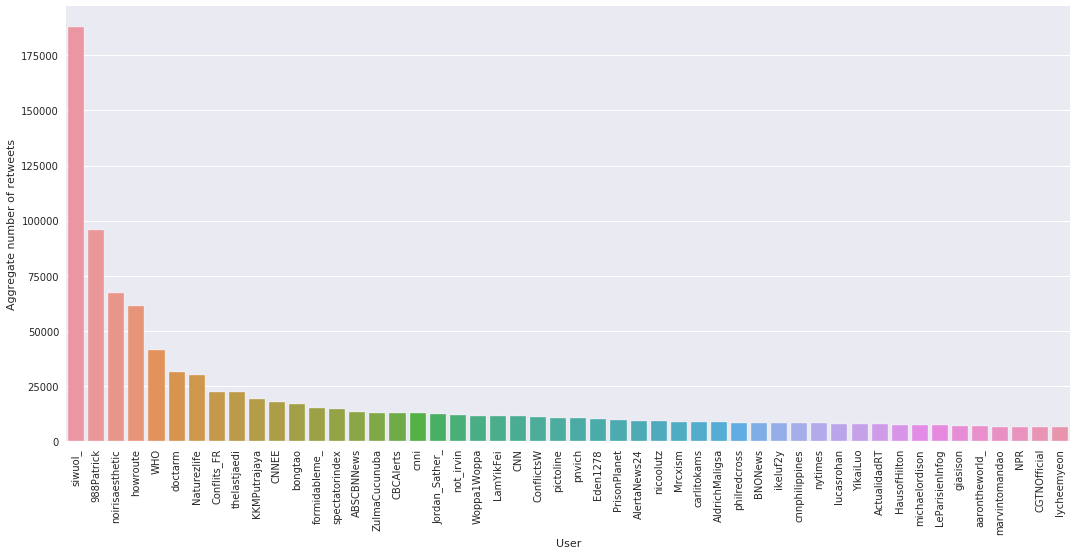

In [57]:
plt.figure(figsize=(18,8))
most_rt_users = list(tweets_by_author[['retweets']].sum().sort_values('retweets', ascending=False).head(50).index)
rts_count = list(tweets_by_author[['retweets']].sum().sort_values('retweets', ascending=False).head(50)['retweets'])
fig = sns.barplot(x=most_rt_users, y=rts_count)
fig.set(xlabel='User', ylabel='Aggregate number of retweets')
fig.set_xticklabels(labels=most_rt_users, rotation=90)
plt.show()

#### Most liked authors

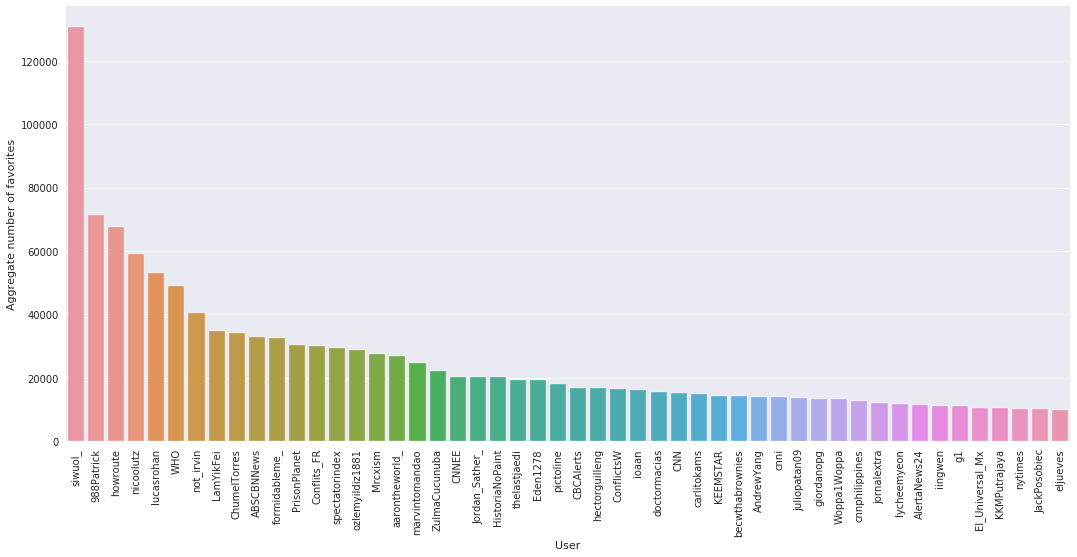

In [58]:
plt.figure(figsize=(18,8))
most_fav_users = list(tweets_by_author[['favorites']].sum().sort_values('favorites', ascending=False).head(50).index)
favs_count = list(tweets_by_author[['favorites']].sum().sort_values('favorites', ascending=False).head(50)['favorites'])
fig = sns.barplot(x=most_fav_users, y=favs_count)
fig.set(xlabel='User', ylabel='Aggregate number of favorites')
fig.set_xticklabels(labels=most_fav_users, rotation=90)
plt.show()

#### Network of interactions

A network of interactions will be built to study how Twitter users interact between each other. Nodes in the network are users that appear in conversations about coronavirus as either authors or mentioned in tweets.

In [161]:
users_df = user_mentions_df
users_df['username'] = users_df['username'].str.replace('@','')
users_df = users_df.rename(columns={'mention_count': 'mentions'})

In [162]:
user_tweets_df = pd.DataFrame.from_dict({'username': tweets_authors_count.index,
                                         'tweets': tweets_authors_count['tweet_id']})
user_tweets_df.index = np.arange(user_tweets_df.shape[0])

In [163]:
users_df = pd.merge(users_df, user_tweets_df, on='username', how='outer')

In [165]:
users_df = users_df.fillna(0)

In [166]:
users_df.sort_values('mentions', ascending=False).head()

,username,mentions,tweets
7,WHO,2137.0,133.0
100,YouTube,2128.0,0.0
15,CDCgov,935.0,12.0
502,MailOnline,698.0,31.0
872,lopezobrador_,652.0,0.0


In [167]:
# compute interactions
interactions_given = defaultdict(set)
interactions_received = defaultdict(set)
for index, tweet in tweets_with_mentions.iterrows():
    mentions = tweet['mentions'].split()
    user = tweet['username']
    user = user.replace('@','')
    for mention in mentions:
        mention = mention.replace('@','')
        interactions_given[user].add(mention)
        interactions_received[mention].add(user)

In [99]:
def compute_interaction_string(user, interaction_dict):
    if user['username'] in interaction_dict.keys():
        return ' '.join(interaction_dict[user['username']])
    else:
        return np.nan

In [168]:
users_df['interactions_in'] = users_df.apply(compute_interaction_string, args=[interactions_received], 
                                                   axis=1)

In [169]:
users_df['interactions_out'] = users_df.apply(compute_interaction_string, args=[interactions_given], axis=1)

In [149]:
def compute_total_interactions(user, inter_key):
    if isinstance(user[inter_key], float):
        # it is nan
        return 0
    else:
        return len(user[inter_key].split())

In [170]:
users_df['total_interactions_in'] = users_df.apply(compute_total_interactions, args=['interactions_in'], axis=1) 

In [171]:
users_df['total_interactions_out'] = users_df.apply(compute_total_interactions, args=['interactions_out'], axis=1)

#### Users ordered by the number of unique mentions given

In [172]:
users_df.sort_values('total_interactions_out', ascending=False).head()

,username,mentions,tweets,interactions_in,interactions_out,total_interactions_in,total_interactions_out
150034,makoto_au_japon,0.0,167.0,NaN,OpIndia_com KuenselOnline LCI GreekReporter Th...,0,103
12760,greg_folkers,3.0,110.0,audvin V2019N Wes_Andrews,SCMPNew BerkeleyJr arambaut CatharinePaules co...,3,71
84390,RolandBlasini,0.0,16.0,NaN,canistropr drcorazon2016 greenwichtime trueblu...,0,49
13584,CurtisSChin,1.0,38.0,pauldrisley,cathaypacific hanrongli CDCDirector iingwen ha...,1,46
155943,muhitreza,0.0,7.0,NaN,SanaSaeed KamalaHarris JoeBiden jaketapper Maz...,0,39


#### Graph of interactions

Compute interactions graph based on the interactions received. Two users are connected if interacted through at least one mention.

In [173]:
G=nx.Graph()
edge_tuples = []
for index, user in users_df[users_df['total_interactions_in']>0].iterrows():
    interactions_in = user['interactions_in'].split()
    user_name = user['username']
    for interaction_in in interactions_in:
        edge_tuples.append((user_name, interaction_in))
G.add_edges_from(edge_tuples)

In [174]:
# write to 
nx.write_gexf(G, "coronavirus_interactions.gexf")

![title](coronavirus_net.png)

---
## Hashtags

In [59]:
tweets_with_hashtags = tweets[~tweets['hashtags'].isna()]

In [60]:
print('There are {} tweets with hashtags in the text'.format(tweets_with_hashtags.shape[0]))

There are 106327 tweets with hashtags in the text


In [74]:
hashtags = defaultdict(int)
for index, tweet in tweets_with_hashtags.iterrows():
    tweet_hashtags = tweet['hashtags'].split()
    for tweet_hashtag in tweet_hashtags:
        hashtags[tweet_hashtag.lower()] += 1

In [75]:
hashtags_df = pd.DataFrame.from_dict({'hashtag': list(hashtags.keys()), 
                                      'hashtag_count': list(hashtags.values())})

In [77]:
# Filter out tweets with # as hashtag
hashtags_df = hashtags_df[hashtags_df['hashtag']!='#']
# Filter out tweets with #coronavirus as hashtag
hashtags_df = hashtags_df[hashtags_df['hashtag']!='#coronavirus']

#### Most used hashtags (excluding coronavirus and alike)

In [85]:
hashtags_df = hashtags_df.sort_values('hashtag_count', ascending=False)
hashtags_df.head(10)

,hashtag,hashtag_count
31,#china,10264
11,#wuhan,8787
3,#2019ncov,2735
56,#coronavirusoutbreak,2566
27,#virus,2085
21,#ncov2019,2019
46,#coronovirus,1918
4,#wuhancoronavirus,1864
30,#wuhanpneumonia,1755
167,#health,1451


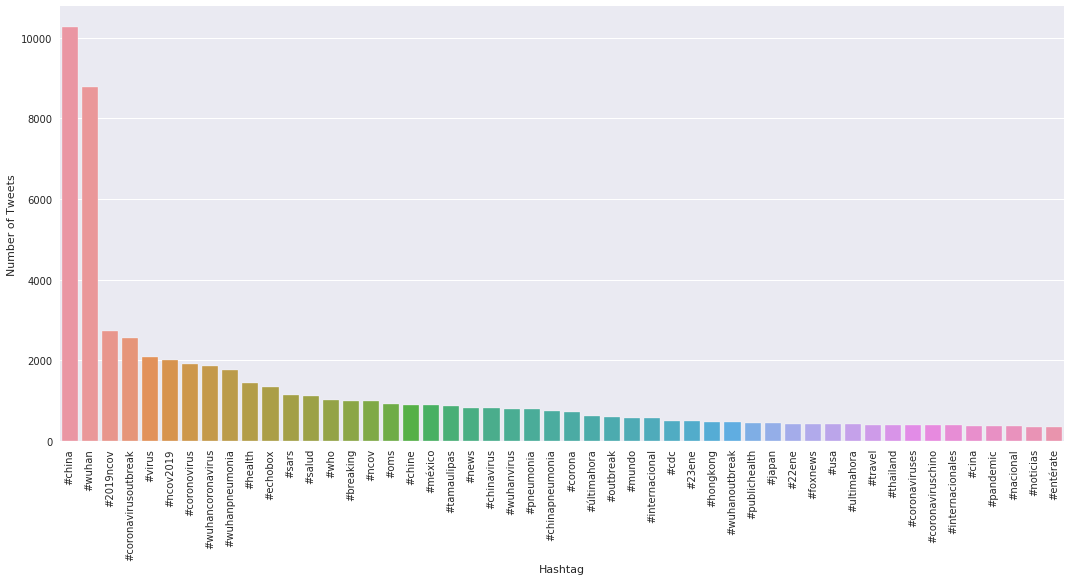

In [86]:
plt.figure(figsize=(18,8))
l_hashtags = list(hashtags_df.hashtag)[:50]
l_hashtags_count = list(hashtags_df.hashtag_count)[:50]
fig = sns.barplot(x=l_hashtags, y=l_hashtags_count)
fig.set(xlabel='Hashtag', ylabel='Number of Tweets')
fig.set_xticklabels(labels=list(hashtags_df.hashtag), rotation=90)
plt.show()

Visualize hashtags in a worldcloud

In [89]:
# concatenate hashtags
all_hashtags = " ".join(hashtag for hashtag in l_hashtags)
hashtags_wordcloud = WordCloud(background_color="white", width=1024, height=768).generate(all_hashtags)

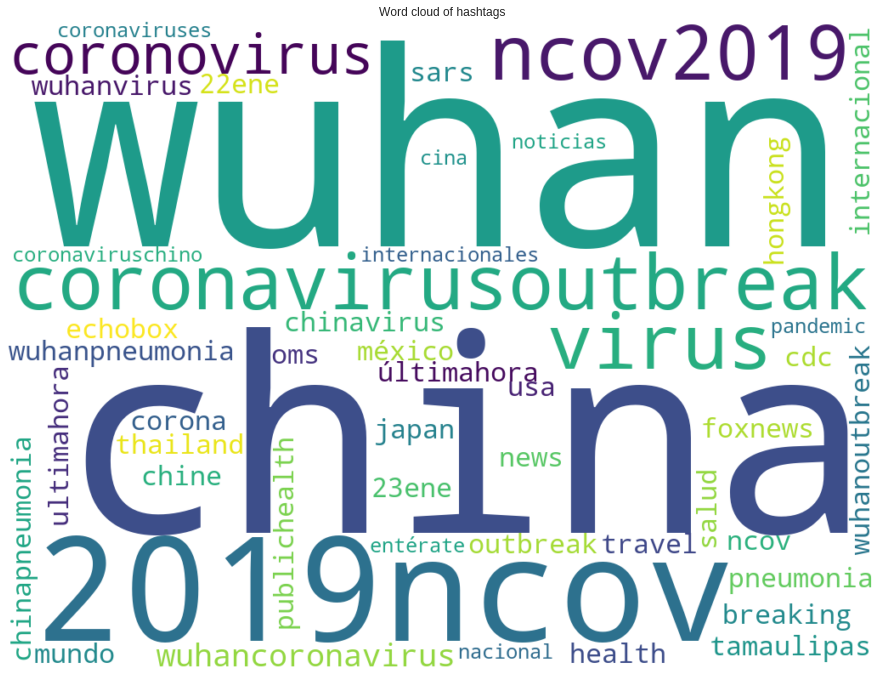

In [90]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.imshow(hashtags_wordcloud.recolor(random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud of hashtags')
# show word clouds
plt.show()

---
## Links

In [91]:
tweets_with_links = tweets[~tweets['urls'].isna()]

In [93]:
print('There are {0} ({1}%) tweets with links'.format(tweets_with_links.shape[0],
                                                      round(100*tweets_with_links.shape[0]/tweets.shape[0],0)))

There are 184033 (58.0%) tweets with links


In [94]:
links = defaultdict(int)
for index, tweet in tweets_with_links.iterrows():
    tweet_links = tweet['urls'].split()
    for tweet_link in tweet_links:
        links[tweet_link] += 1

In [95]:
links_df = pd.DataFrame.from_dict({'link': list(links.keys()), 
                                   'link_count': list(links.values())})

In [96]:
links_df = links_df.sort_values('link_count', ascending=False)

In [100]:
links_df = links_df[links_df['link'].str.find('twitter.com')==-1]

In [103]:
pd.set_option('display.max_colwidth', None)
links_df.head(10)

,link,link_count
12669,https://www.cnn.com/2020/01/21/health/wuhan-coronavirus-first-us-case-cdc-bn/index.html,532
18240,https://patents.justia.com/patent/10130701,331
946,https://www.bbc.co.uk/news/world-asia-china-51217455,238
20654,https://www.milenio.com/estados/coronavirus-profesor-ipn-viajo-china-portador,237
12864,https://nyti.ms/2NMGhn3,235
85,https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6,230
20429,https://actualidad.rt.com/actualidad/340726-prohibir-salir-wuhan-originarse-coronavirus,226
20929,https://www.foxnews.com/health/china-quarantines-wuhan-coronavirus-outbreak-reports,225
13891,https://www.foxnews.com/health/first-case-coronavirus-us-seattle,222
13190,https://www.washingtonpost.com/health/2020/01/21/coronavirus-us-case/,217


In [127]:
# compute domain of links
links_df['domain'] = links_df.apply(lambda row: tldextract.extract(row['link']).domain, axis=1) 

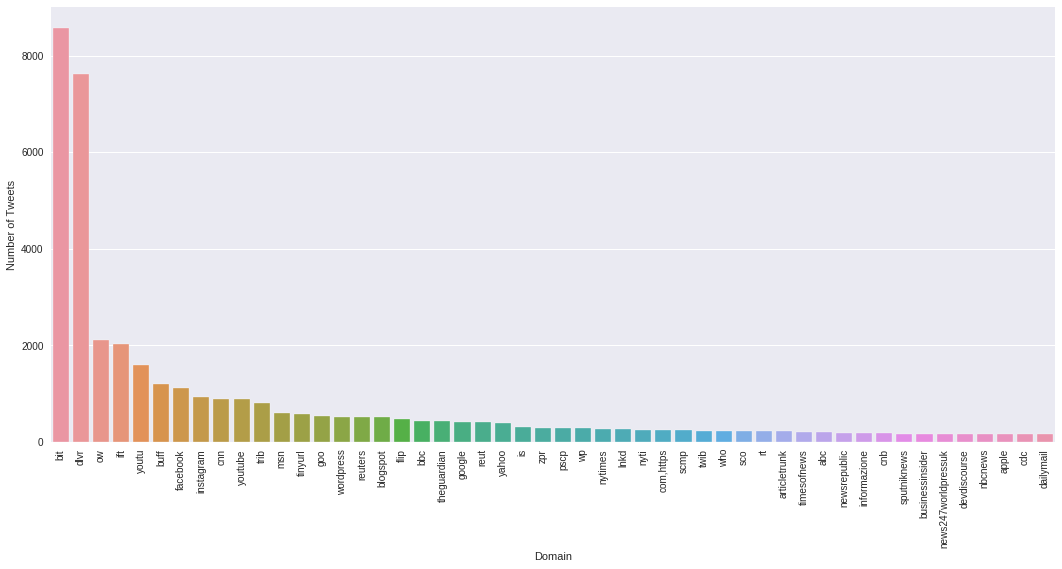

In [135]:
plt.figure(figsize=(18,8))
l_domains = list(links_df.groupby('domain').count().sort_values('link', ascending=False).head(50).index)
l_domains_count = list(links_df.groupby('domain').count().sort_values('link', ascending=False).head(50)['link'])
fig = sns.barplot(x=l_domains, y=l_domains_count)
fig.set(xlabel='Domain', ylabel='Number of Tweets')
fig.set_xticklabels(labels=l_domains, rotation=90)
plt.show()

---
## Tweets

#### Top-10 most retweeted tweets

In [145]:
tweets.sort_values('retweets', ascending=False)[['tweet_id','tweet', 'username', 'retweets']].head(10)

,tweet_id,tweet,username,retweets
85175,1220259934488547328,rt to save life #coronavirus pic.twitter.com/xQ8z2ihrAu,siwuol_,187737
71257,1220190098878271490,It’s not a joke . Share guys and stay safe #coronavirus pic.twitter.com/nmcciR8up3,988Patrick,95927
199119,1219285703798022147,"BREAKING NEWS: This is not a scene from some apocalyptic horror movie, this is a #coronavirus outbreak in China. The SARS like virus has already spread to four countries and infected more than 1700 people. US airports are monitored. Be on alert, stay safe! pic.twitter.com/PIc7NYvsGO",howroute,48626
131236,1220378320333766656,มึงงง อันนี้คือข้างถนนเลย คนติดเชื้อ #ไวรัสโคโรนา ล้มฟุบข้างถนนนอนแน่นิ่งไม่ขยับ คนที่อยู่ในเหตุการณ์ก็พากันทำอะไรไม่ถูกเลย #coronavirus #WuhanCoronavirus pic.twitter.com/1wLXeE4nym,noirisaesthetic,48295
200564,1219310638293340161,นักท่องเที่ยวชาวอังกฤษที่มาเที่ยวไทย อาจจะติดเชื้อ Corona virus อู่ฮั่น มีอาการป่วยที่เกาะพีพี ถูกส่งตัวมารักษาที่จ.ภูเก็ต อาจจะเป็นชาวตะวันตกรายแรกที่ต้องสงสัยว่าติดเชื้อนอกประเทศจีน รอยืนยันผลตรวจอีกที https:// twitter.com/love_Thai_555/ status/1219274648480776192 …,doctarm,31516
83964,1220255527705272320,”ทำไม #coronavirus สามารถแพร่กระจายอย่างรวดเร็วและแพร่ไปยังประเทศ อื่นๆในเอเชีย แม้แต่ในอเมริกา” ซึ่ง”หวู่ฮั่น” ไม่ใช่เมืองที่มีชื่อเสียงอย่างปักกิ่งเซี่ยงไฮ้ หรือกวางโจว แต่นั่นคือที่ที่มีการระบาด ขนาดและเศรษฐกิจของเมือง สามารถอธิบายได้ว่าทำไม มาดูข้อมูลกัน (1) #ไวรัสโคโรนา pic.twitter.com/JgGSsLdTGd,Naturezlife,23123
161375,1220430582653640704,please read this and stay safe everyone #CoronavirusOutbreak #coronavirus pic.twitter.com/Ek6tbWPziq,thelastjaedi,22426
141062,1220394986836856832,อันนี้วูบล้มกันเห็นๆ เลย เหมือนว่าตอนนี้เหตุการณ์แบบนี้เกิดขึ้นทั่วเมือง #Wuhan ละอะ อันตรายมากจริงๆ แล้วเห็นข่าวผ่านตาว่าแค่ใส่แมสก์อาจไม่พอที่จะป้องกันได้แล้วด้วย . #ไวรัสโคโรนา #Coronavirus https:// twitter.com/IsChinar/statu s/1220379066764877824/video/1 …,noirisaesthetic,16983
8202,1219452062347350018,ตอนนี้ใครมีหน้ากากกันฝุ่น ใส่ตลอดเวลาที่อยู่ในสถานที่สาธารณะดีกว่าครับ นอกจาก PM2.5 ที่น่าจะอยู่กับเราอีกนานแล้ว ตอนนี้ทางการจีนคอนเฟิร์มแล้วว่า Corona virus อู่ฮั่นสามารถติดต่อจากคนสู่คนได้ และวีคเอนด์นี้คนจีนจำนวนมากจะบินมาเที่ยวไทยช่วงตรุษจีน ป้องกันไว้ครับ #ฝุ่นPM25,bongtao,16970
26306,1219655559302934529,"SO ANG TRUE REASON SA BREAK-UP NG JADINE AY Now that I got your attention, the 2019 novel coronavirus , the virus that's currently spreading the nearby countries of China, comes from animals that are being sold and slaughtered for consumption in China, specifically Wuhan. (1/n)",formidableme_,15013


#### Most retweeted tweet

In [267]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">rt to save life <a href="https://twitter.com/hashtag/coronavirus?src=hash&amp;ref_src=twsrc%5Etfw">#coronavirus</a> <a href="https://t.co/xQ8z2ihrAu">pic.twitter.com/xQ8z2ihrAu</a></p>&mdash; siwuol 🐈 (@siwuol_) <a href="https://twitter.com/siwuol_/status/1220259934488547328?ref_src=twsrc%5Etfw">January 23, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(tweet_html)

#### Top-10 most liked tweets

In [144]:
tweets.sort_values('favorites', ascending=False)[['tweet_id','tweet', 'username' , 'favorites']].head(10)

,tweet_id,tweet,username,favorites
85175,1220259934488547328,rt to save life #coronavirus pic.twitter.com/xQ8z2ihrAu,siwuol_,130641
71257,1220190098878271490,It’s not a joke . Share guys and stay safe #coronavirus pic.twitter.com/nmcciR8up3,988Patrick,71418
139462,1220392191220224003,"pessoal falando da sopa de morcego e os caraio minha mãe, porém, já veio com a teoria de que o coronavírus é obra dos estados unidos pra fazer o resto do mundo parar de comprar da china uma visionária certamente",nicoolutz,58929
199119,1219285703798022147,"BREAKING NEWS: This is not a scene from some apocalyptic horror movie, this is a #coronavirus outbreak in China. The SARS like virus has already spread to four countries and infected more than 1700 people. US airports are monitored. Be on alert, stay safe! pic.twitter.com/PIc7NYvsGO",howroute,51832
53260,1219766920641052672,"Kailan kaya mas magiging affected ang mga Filipino sa political, social, and health issue kesa sa pagbreak ng isang love team China is taking WPS: kebs Digong kills adik: Keri lang Taal erupted: omg tru ba Coronavirus : oks Jadine broke up: PUTANGINA TANGINA AYOKO NA MABUHAY",not_irvin,40373
66994,1220174573338906624,Hong Kong’s first Wuhan coronavirus patient. 22-1-2020. pic.twitter.com/7RxfmFJS5J,LamYikFei,34708
26306,1219655559302934529,"SO ANG TRUE REASON SA BREAK-UP NG JADINE AY Now that I got your attention, the 2019 novel coronavirus , the virus that's currently spreading the nearby countries of China, comes from animals that are being sold and slaughtered for consumption in China, specifically Wuhan. (1/n)",formidableme_,32449
265340,1219990412535853057,"Analizan dos casos de coronavirus en México. ¡Justo cuando el sector salud está en su mejor momento! Ya entendimos la indirecta, Dios.",ChumelTorres,30922
92035,1220291296360910848,"Coronavirus gibi gerçek salgınlar ortaya çıktığında modern tıp karşıtları bir süre susar; bilim insanları virüsü tanımlar, kaynağını belirler, tanı yöntemlerini, aşısını geliştirir, yayılmasını önler, hastalık kontrol altına alındıktan sonra bahsedilen kişiler konuşmaya başlar.",ozlemyildiz1881,28891
15843,1219558677163565056,"Pagsabog ng bulkan, lindol, breakup ng JaDine, coronavirus scare. January pa lang. January. Pa. Lang.",aarontheworld_,26947


### Fake news

In [182]:
fake_news_keywords = ['mosquito', 'orina', 'urine', 'frio', 'nieve', \
                      'cold', 'snow', 'cocaine', 'cocaina', \
                      'objetos', 'billetes', 'monedas', 'objects', \
                      'coins', 'eigth meters', 'ocho metros', \
                      'ultravioleta', 'ultraviolet', 'alcohol', 'cloro', \
                      'chlorine', 'letter', 'package', 'carta', 'paquete', \
                      'neumonía', 'pneumonia', 'nariz', 'nose', 'ajo',
                      'garlic', 'aceite de sésamo', 'sesame oil', \
                      'antibióticos', 'antibiotics']

In [188]:
tweets.loc[0,'tweet'] = 'mosquito orina sesame oil'

In [189]:
tweets.iloc[0,:]['tweet']

'mosquito orina sesame oil'

In [208]:
tweets[tweets['tweet'].str.find('vacine')!=-1][['tweet_id', 'username', 'tweet']].head(50)

,tweet_id,username,tweet
182042,1220476570659446784,Whitespacer,Satanic shit. Scaring the world into more vacines one corona virus at a time.


---
## Geolocalized Tweets

In [59]:
tweets_with_geo = tweets[~tweets['geo'].isna()]

In [60]:
print('There are {0} tweets with geolocalization information'.format(tweets_with_geo.shape[0]))

There are 0 tweets with geolocalization information


## TODO:

1. Analyze language of tweets
2. Topic modeling of tweets
3. Most frequent words in tweets
4. Sentiment analysis of tweets
5. Geolocalize tweets
6. Analyze whether text of tweets contains information about fake news of coronavirus
7. Check quality of youtube videos shared on tweets. Example of papers that might be interesting to read in relation to assessing the quality of youtube videos
-- [A Quality Assessment of Cardiac Auscultation Material on YouTube](https://onlinelibrary.wiley.com/doi/full/10.1002/clc.22080)-- [Identifying Measures Used for Assessing Quality of YouTube Videos with Patient Health Information: A Review of Current Literature](https://www.i-jmr.org/2013/1/e6/)
-- [YouTube as a source of patient information on gallstone disease](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3983464/)